This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

# Chapter 1: Introduction: From Batch to Online Machine Learning

## Drift

### The Friedman-Drift Data Set

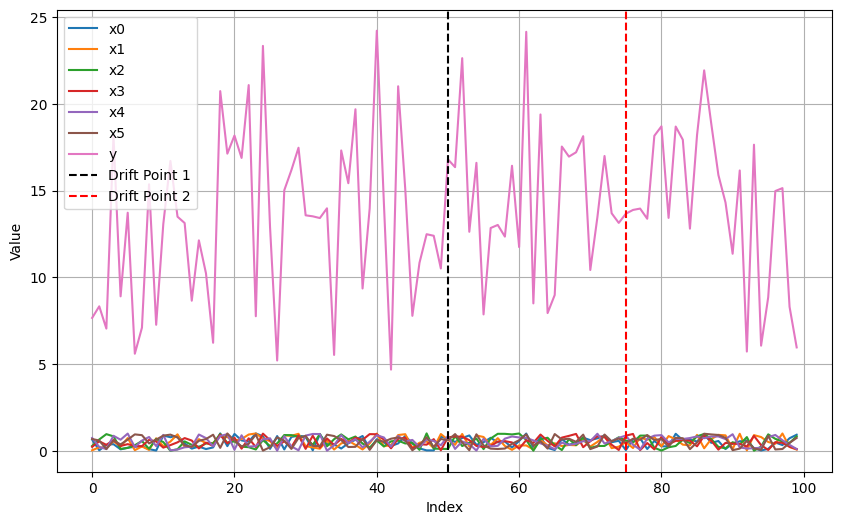

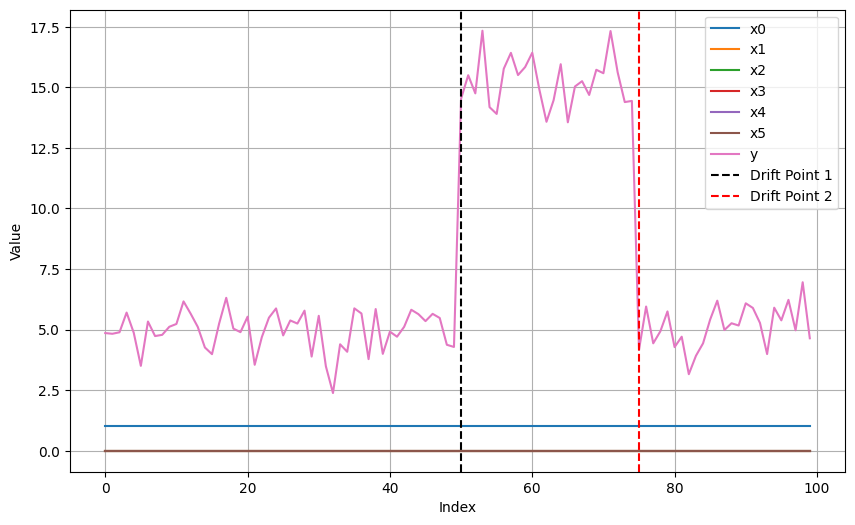

In [1]:
from spotpython.plot.ts import plot_friedman_drift_data
plot_friedman_drift_data(n_samples=100, seed=42, change_point1=50, change_point2=75, constant=False, filename="./figures/ch01_friedman_drift_change_point.pdf")
plot_friedman_drift_data(n_samples=100, seed=42, change_point1=50, change_point2=75, constant=True, filename="./figures/ch01_friedman_drift_change_point_constant.pdf")

## Stochastic gradient descent

### Motivation

Linear regression is a powerful tool for modeling linear relationships in data.
It does this by finding the value of $\beta$ that minimizes a given cost function **L**. 
For this, there is a closed-form solution (normal equation) given by:

$$\hat\beta = (X^{T}X)^{-1}X^{T}y$$

In this equation, $\hat\beta$ is the value of $\beta$ that minimizes the cost function, **y** is the vector of objective values.

If there is an exact solution, why don't we use it to calculate the values of $\beta$?

The answer is that as the size of the data sets increases, the computational complexity increases. To find a solution quickly for large data sets, gradient descent algorithms can be used. These solve the problem as an iterative process. The simplest approach is batch gradient descent, which uses the full data set at all times. However, this can be more time consuming.

## Data generation

We consider the linear relationship between two variables $x$ and $y$:

$$y = 6x + 2$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def fun_lin(X, sigma):
        y = 2.0 + (6.0 * X) # ground truth, to be rediscovered b_0 = 2, b_1 = 6
        if sigma != 0:
            noise_y = np.array([], dtype=float)
            for i in y:
                noise_y = np.append(
                    noise_y, i + np.random.normal(loc=0, scale=sigma, size=1)
                )
            return noise_y
        else:
            return y
x = np.linspace(start=1, stop=10)
y = fun_lin(x, sigma = 2.0)

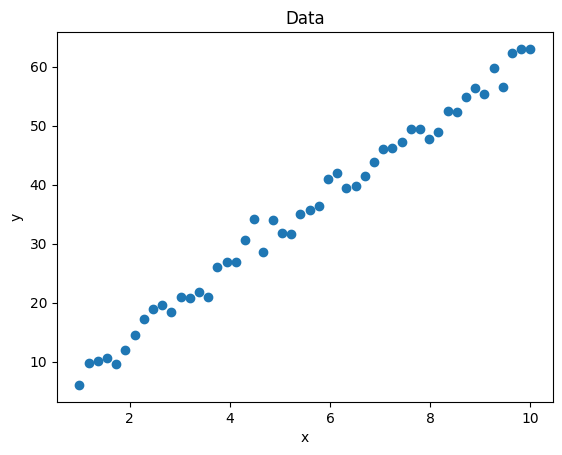

In [3]:
points = np.array([x,y])
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()

## The error function

The error function calculates the error between the predicted values and the actual values. We use the quadratic error function:

In [4]:
def ssr_gradient(x, y, b):
    res = b[0] + b[1] * x - y
    return res.mean(), (res * x).mean()

## Gradient Descent

In [5]:
def gradient_descent(gradient, x, y, start, learn_rate=0.0001 , n_iter=50, tolerance = 1e-6):
    """Performs gradient descent optimization for a function whose gradient is known.

    Args:
        gradient (callable): The gradient of the function to be minimized.
        start (float): The starting point for the optimization.
        learn_rate (float): The learning rate for the gradient descent step.
        n_iter (int): The number of iterations to perform.
        tolerance (float): The stopping criteria.

    Returns:
        float: The value of x that optimizes the function.

    Examples:
        >>> gradient_descent(ssr_gradient,x, y, start=[2.5, 6.5], learn_rate=0.00001, n_iter=1000)
            b: 2.474687807007182, m:6.332722751822451
    """
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * np.array(gradient(x,y, vector))
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector

In [6]:
b, m = gradient_descent(ssr_gradient, x, y, start=[2.5, 6.5], learn_rate=0.00001, n_iter=1000)
print(f"b: {b}, m:{m}")

b: 2.475531197860374, m:6.341322417192591


### Plot the line of the best fit

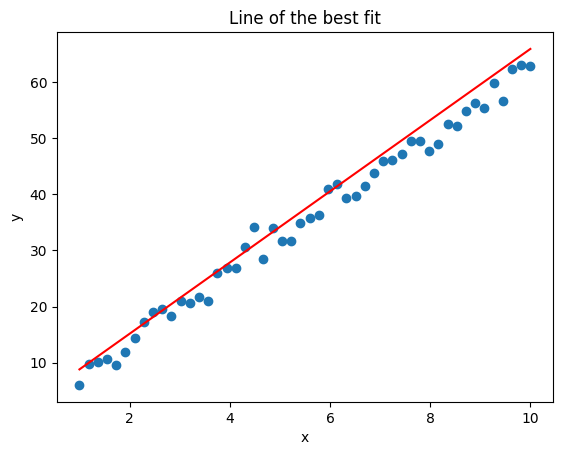

In [7]:
#Plot dataset
plt.scatter(x, y)
#Predict y values
pred = m * x + b
#Plot predictions as line of best fit
plt.plot(x, pred, c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line of the best fit')
plt.show()

## Stochastic Gradient Descent (SGD).

SGD uses only a subset of the training data in each step, which speeds up the calculation. On the other hand, due to its stochastic nature. This algorithm is much less regular than Batch Gradient Descent. Instead of decreasing smoothly until it reaches the minimum, the cost function bounces up and down, decreasing only on average. Over time, it will end up very close to the minimum, but once it gets there, it will bounce back and forth and never settle down. Once the algorithm stops, the final parameter values will be good, but not optimal.

### How does a gradient descent algorithm work?

1. choose a random starting point $x_0$
2. $x_1$ = $x_0 - r[(df/dx) \text{ of } x_0]$
3. $x_2$ = $x_1 - r[(df/dx) \text{ from } x_1]$
4. continue until convergence.

Where $r$ is the learning rate and $df/dx$ is the gradient function to minimize the loss function.

## SGD Implementation

We will implement the Stochastic Gradient Descent (SGD) function and test it on our own synthetic data.
We will cover the following steps:

1. create our own synthetic data, with a sample of at least 50 entities. With one dependent variable and one independent variable.
2. visualize our data
3. define the gradient function
4. define the SGD function. The following parameters are needed:
     - Gradient: Defines the gradient function
     - x: The values of the independent variables
     - y: The values of the dependent variables
     - start: a vector that serves as a starting point for our search
     - learn_rate: is the learning rate that controls the size of the vector update
     - n_iter: number of iterations
     - tolerance: termination criteria
     - k: Number of point pairs used in each iteration.
5. use our self-build function with the following parameters
     - start: [2.5, 6.5]
     - learn_rate: 0.0001
     - n_iter: 10000
     - tolerance = 1e-6
     - k = 30

### Definition of the SGD Function

In [8]:
def SGD(gradient, x, y, start, learn_rate=0.1 , n_iter=50, tolerance = 1e-6, k = 30):
    """ Stochastic gradient function to find efficient values for intercept and slope

    Args:
        gradient: The gradient function defined above.
        x (float): Input value independent variable (1-dim)
        y (float): input value dependent variable (1-dim)
        vecctor (float): np.array containing initial values for intercept and slope
        learn_rate (float): Learn rate
        n_iter (int): number of iterations
        tolerance (float): the value at which the process is terminated if the slope is smaller
        k (int): number of point pairs used in each iteration

    Returns:
        values for the intercept (float) and the slope (float)

    """
    vector = start
    iteration = 1
    if k > x.shape[0]:
            k = x.shape[0]
    while iteration <= n_iter:
        indices = np.random.choice(x.shape[0], k, replace=False)
        x_sample = x[indices]
        y_sample = y[indices]
        diff = -learn_rate * np.array(gradient(x_sample,y_sample, vector))
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
        iteration +=1
    return vector

#### Fit the SGD with the given parameter combination

In [9]:

b, m = SGD(ssr_gradient, x, y, start=[2.5, 6.5], learn_rate=0.0001, n_iter=10000, k = 3)
b, m

(2.340582155904516, 6.01103307526846)

## Visualisation of the SGD-Results

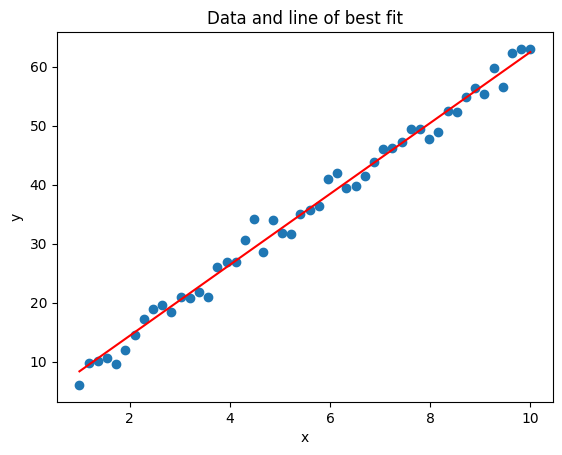

In [10]:
plt.scatter(x, y)
pred = m * x + b
plt.plot(x, pred, c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data and line of best fit')
plt.show()

## Explanation why SGD is better suited for large data sets.

Unlike batch gradient descent, stochastic gradient descent optimizes only a subsample. Since less data needs to be adjusted in each iteration, the processing time of the algorithm is significantly accelerated.

## Explanation of why SGD does not give you the optimal solution.

Instead of decreasing smoothly until it reaches the minimum, the cost function bounces up and down, decreasing only on average. When it crosses, it will be very close to the minimum, but once it gets there, it will continue to bounce back and forth and never settle down. Once the algorithm stops, the final parameter values are good, but not optimal.